Deep Learning T2-ADC example - adapted from deep_ivim_demo

Code for unsupervised fitting of models to qMRI data.

Code is adapted from Barbieri et al. https://github.com/sebbarb/deep_ivim/blob/master/deep_ivim_demo.ipynb 


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#define t2-adc model
def t2adc(b,TE,D,T2):
    return np.exp(-b*D) * np.exp(-(TE - np.min(TE))/T2)

In [3]:
#define T2-ADC training data instead
b_values = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])
TE = np.array([0.058, 0.058, 0.058, 0.058, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2])
# training data
num_samples = 100000
X_train = np.zeros((num_samples, len(b_values)))
for i in range(len(X_train)):
    D = np.random.uniform(0.5, 2)
    T2 = np.random.uniform(0.02, 0.3)
    X_train[i, :] = t2adc(b_values, TE, D, T2)

# add some noise
X_train_real = X_train + np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train_imag = np.random.normal(scale=0.01, size=(num_samples, len(b_values)))
X_train = np.sqrt(X_train_real**2 + X_train_imag**2)

print(np.shape(X_train))


(100000, 16)


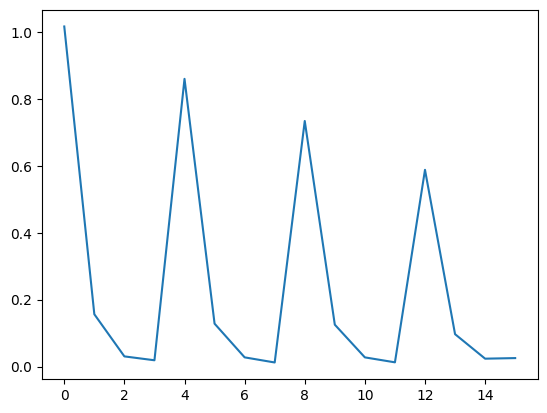

In [4]:
plt.plot(X_train[10,:])

In [5]:
#load some real data
filepath = 
grad = 

0.9025500908586126

In [6]:
#define the t2-adc neural network

nparams = 2

# class Net(nn.Module):
#     def __init__(self, b_values_no0, TE_nomin ):
#         super(Net, self).__init__()

#         self.b_values_no0 = b_values_no0
#         self.TE_nomin = TE_nomin
#         self.fc_layers = nn.ModuleList()
#         for i in range(3): # 3 fully connected hidden layers
#             self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
#         self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), nparams))

#     def forward(self, X):
#         params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
#         D = params[:, 0].unsqueeze(1)
#         T2 = params[:, 1].unsqueeze(1)
        
#         X = torch.exp(-self.b_values_no0*D) * torch.exp(-(self.TE_nomin - torch.min(self.TE_nomin))/T2) 

#         return X, D, T2

#not getting getting rid of the first (normalised) datapoint
class Net(nn.Module):
    def __init__(self, b_values, TE ):
        super(Net, self).__init__()

        self.b_values = b_values
        self.TE = TE
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), nparams))

    def forward(self, X):
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        D = params[:, 0].unsqueeze(1)
        T2 = params[:, 1].unsqueeze(1)
        
        X = torch.exp(-self.b_values*D) * torch.exp(-(self.TE - torch.min(self.TE))/T2) 

        return X, D, T2

In [7]:
# make the Network
#b_values_no0 = torch.FloatTensor(b_values[1:])
#TE_nomin = torch.FloatTensor(TE[1:])

b_values_tor = torch.FloatTensor(b_values)
TE_tor = torch.FloatTensor(TE)

#net = Net(b_values_no0, TE_nomin)
net = Net(b_values_tor, TE_tor)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)  

In [8]:
#create batch queues
batch_size = 128
num_batches = len(X_train) // batch_size

#X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized

trainloader = utils.DataLoader(torch.from_numpy(X_train.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [9]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
for epoch in range(100): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        X_pred, D_pred, T2_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 422.57it/s]


Loss: 5.028337155061308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 419.93it/s]


Loss: 0.5233095172443427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 406.35it/s]


Loss: 0.2985413856804371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 415.67it/s]


Loss: 0.23099482980614994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 464.67it/s]


Loss: 0.1956345690996386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 480.32it/s]


Loss: 0.1507734689366771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 401.75it/s]


Loss: 0.10542600099142874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 463.79it/s]


Loss: 0.09109802446619142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 463.23it/s]


Loss: 0.08522690748941386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 481.45it/s]


Loss: 0.0823712860365049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 525.22it/s]


Loss: 0.07964068811270408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 499.61it/s]


Loss: 0.07911051998235052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 488.70it/s]


Loss: 0.07825381442671642
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 527.79it/s]


Loss: 0.07663054372824263
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 520.73it/s]


Loss: 0.07656324325216701
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 481.58it/s]


Loss: 0.07587787447118899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 458.39it/s]


Loss: 0.07576108052307973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 454.23it/s]


Loss: 0.07559211686020717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 486.59it/s]


Loss: 0.07505990947538521
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 517.04it/s]


Loss: 0.07458640004915651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 519.56it/s]


Loss: 0.07413393776369048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 493.55it/s]


Loss: 0.0745336603213218
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 439.43it/s]


Loss: 0.0736015153088374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 433.15it/s]


Loss: 0.07418787320784759
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 416.37it/s]


Loss: 0.07344116923923139
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 431.36it/s]


Loss: 0.0737510190665489
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 419.64it/s]


Loss: 0.07299575298384298
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 408.00it/s]


Loss: 0.07307933886477258
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 458.32it/s]


Loss: 0.0733010004987591
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 438.27it/s]


Loss: 0.07331263690139167
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 3


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 440.00it/s]


Loss: 0.07241962921398226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 435.40it/s]


Loss: 0.0727791314420756
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:02<00:00, 375.89it/s]


Loss: 0.07289632214815356
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 400.54it/s]


Loss: 0.07231763681920711
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 479.66it/s]


Loss: 0.07253895176108927
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 469.26it/s]


Loss: 0.07273936829005834
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 469.70it/s]


Loss: 0.07231892416166374
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 3


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 439.21it/s]


Loss: 0.07206128330290085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 480.68it/s]


Loss: 0.07259340148448246
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 488.17it/s]


Loss: 0.0717534742798307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 461.90it/s]


Loss: 0.07265368539083283
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 476.42it/s]


Loss: 0.07205967013578629
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 499.31it/s]


Loss: 0.07251666044612648
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 3


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 471.67it/s]


Loss: 0.07182426164945355
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 4


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 454.69it/s]


Loss: 0.07204195625672583
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 5


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 476.64it/s]


Loss: 0.0724184890059405
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 6


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 466.59it/s]


Loss: 0.07166085571952863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 511.13it/s]


Loss: 0.07259776553109987
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 436.22it/s]


Loss: 0.07186175014794571
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 478.07it/s]


Loss: 0.07181516419223044
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 497.73it/s]


Loss: 0.07191091380082071
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 4


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 472.82it/s]


Loss: 0.07191767753101885
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 5


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 444.99it/s]


Loss: 0.07251695603190456
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 6


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 482.51it/s]


Loss: 0.07133331769000506
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 513.03it/s]


Loss: 0.0719371541053988
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 489.08it/s]


Loss: 0.07196382273104973
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 2


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 480.92it/s]


Loss: 0.07178008701885119
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 3


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 419.88it/s]


Loss: 0.07191701442934573
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 4


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 405.72it/s]


Loss: 0.07184340111416532
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 5


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 393.75it/s]


Loss: 0.07165470605104929
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 6


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 437.11it/s]


Loss: 0.07165112688380759
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 7


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 447.41it/s]


Loss: 0.07200446270144312
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 8


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 509.67it/s]


Loss: 0.0715035317116417
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 9


100%|████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 515.52it/s]

Loss: 0.07212178714689799
Done, best loss: 0.07133331769000506
Done


<All keys matched successfully>

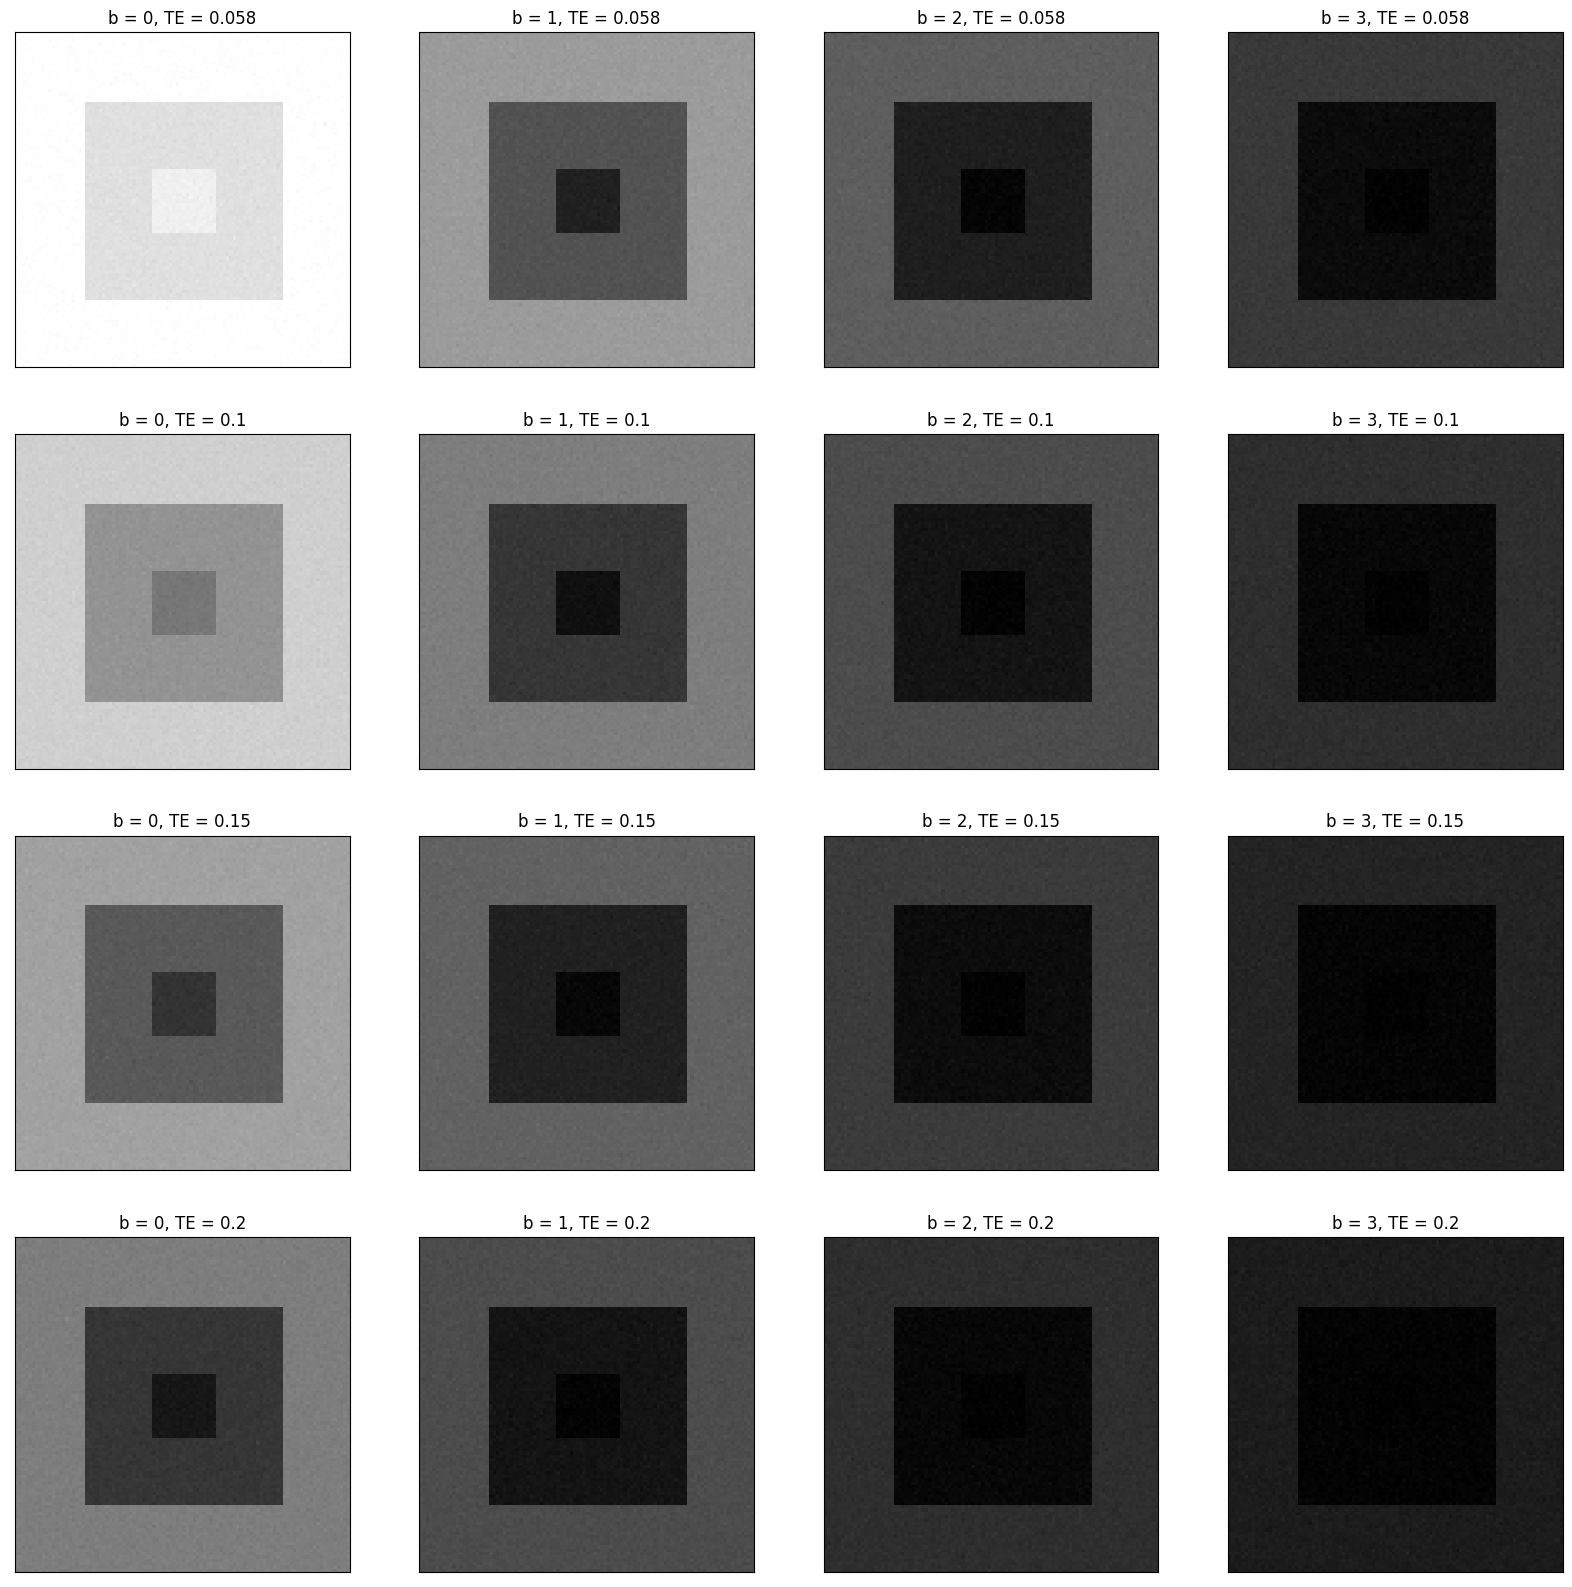

In [10]:
#simulate T2-ADC image 
# define parameter values in the three regions

S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
#S0_region0, S0_region1, S0_region2 = 1, 1, 1

D_region0, D_region1, D_region2 = 2, 1, 0.5
T2_region0, T2_region1, T2_region2 = 0.06, 0.10, 0.2

# image size
sx, sy, sb = 100, 100, len(b_values)
# create image
dwi_image = np.zeros((sx, sy, sb))
D_truth = np.zeros((sx, sy))
T2_truth = np.zeros((sx, sy))


# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*t2adc(b_values, TE, D_region0, T2_region0)
            D_truth[i, j], T2_truth[i, j] = D_region0, T2_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*t2adc(b_values, TE, D_region1, T2_region1)
            D_truth[i, j], T2_truth[i, j] = D_region1, T2_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*t2adc(b_values, TE, D_region2, T2_region2)
            D_truth[i, j], T2_truth[i, j] = D_region2, T2_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(4, 4, figsize=(20,20))
b_id = 0
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray',clim=(0,1600))
        ax[i, j].set_title('b = ' + str(b_values[b_id]) + ', TE = ' + str(TE[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
#plt.subplots_adjust(hspace=-0.6)
plt.show()


In [11]:
#Inference

#put into "voxel" form
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))

# # normalize t2-adc signal
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)

#don't get rid of first point
dwi_image_long_norm = dwi_image_long/S0
#get rid of first
#dwi_image_long_norm = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, D, T2 = net(torch.from_numpy(dwi_image_long_norm.astype(np.float32)))
    
D = D.numpy()
T2 = T2.numpy()


    

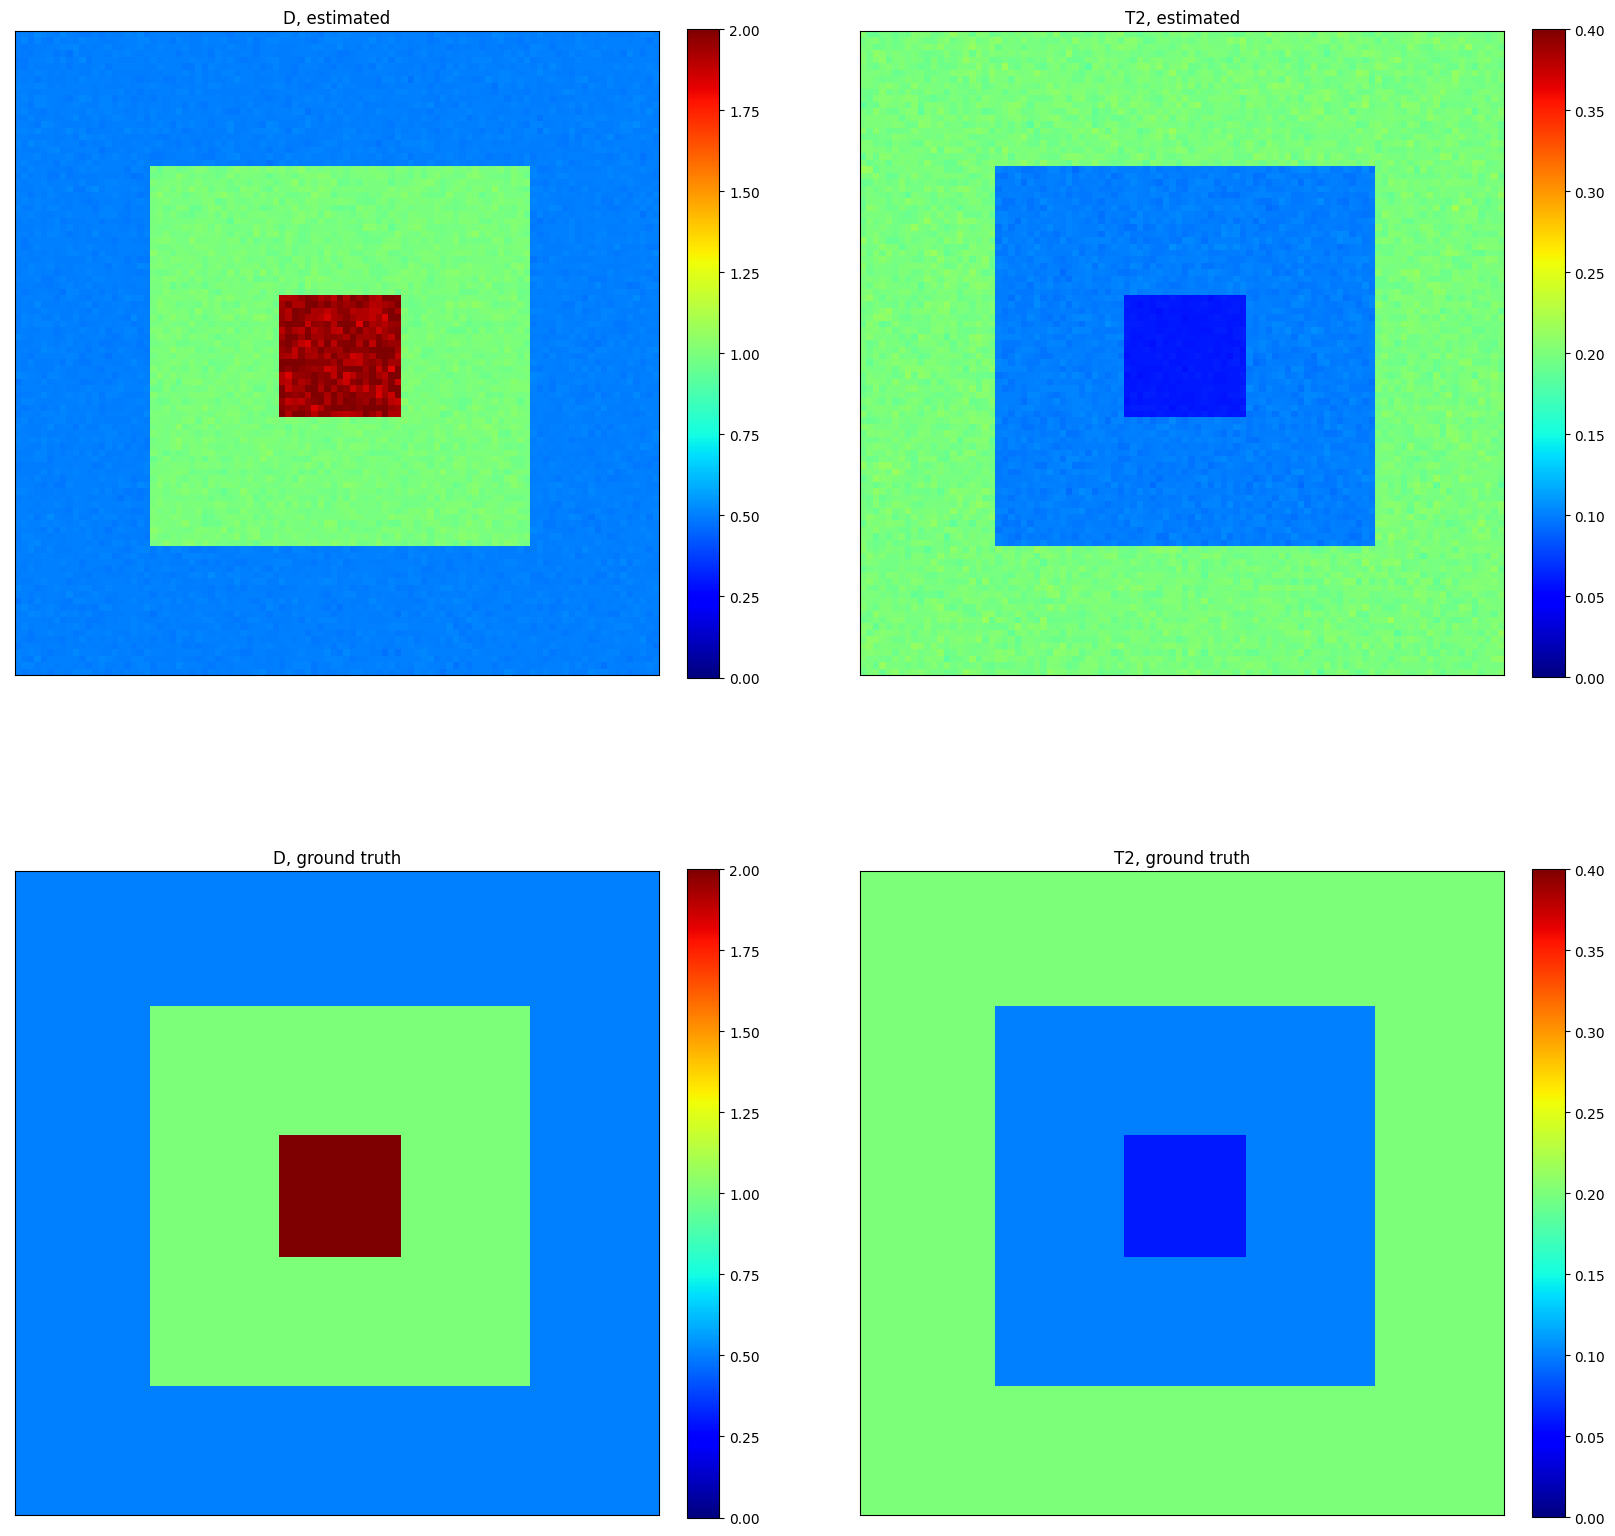

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

D_plot = ax[0,0].imshow(np.reshape(D, (sx, sy)), cmap='jet', clim=(0, 2))
ax[0,0].set_title('D, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(D_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

D_t_plot = ax[1,0].imshow(D_truth, cmap='jet', clim=(0, 2))
ax[1,0].set_title('D, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(D_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

T2_plot = ax[0,1].imshow(np.reshape(T2, (sx, sy)), cmap='jet', clim=(0, 0.4))
ax[0,1].set_title('T2, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(T2_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

T2_t_plot = ax[1,1].imshow(T2_truth, cmap='jet', clim=(0, 0.4))
ax[1,1].set_title('T2, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(T2_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)



plt.show()

In [13]:
print(D[0,0])
print(T2[0,0])

0.49808887
0.20562188


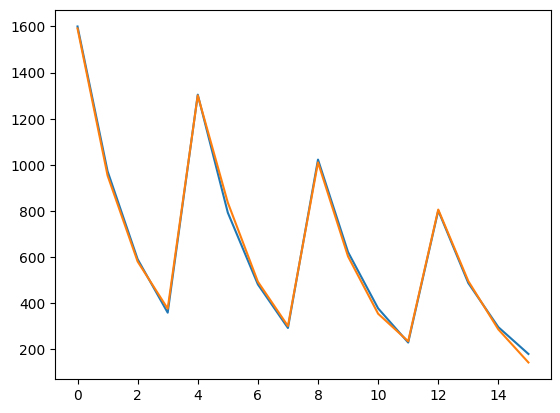

In [14]:
plt.plot(1600*t2adc(b_values,TE,D[0,0],T2[0,0]))
plt.plot(dwi_image_long[0,:])

In [15]:
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)
